In [1]:
import pandas as pd
def make_code(x):
    x = str(x)
    return '0'*(6-len(x)) + x

code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download',header=0)[0]
code_data['종목코드'] = code_data['종목코드'].apply(make_code)
code_list = code_data[code_data['상장일'] < '2017-01-01']['종목코드']
code_data

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,095570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
2,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
3,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,DS단석,017860,기타 화학제품 제조업,바이오에너지,2023-12-22,12월,한승욱,http://dsdansuk.com,경기도
...,...,...,...,...,...,...,...,...,...
2664,카이바이오텍,446600,의약품 제조업,방사성 진단 및 치료 의약품,2022-12-23,12월,김영덕,http://www.kaibiotech.com/,전라북도
2665,코스텍시스템,169670,특수 목적용 기계 제조업,"반도체 웨이퍼 이송장비, 본딩장비",2022-01-21,12월,배준호,http://www.kosteks.com/,경기도
2666,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도
2667,테크엔,308700,전구 및 조명장치 제조업,LED조명장치,2018-12-21,12월,"이지원,박철(각자 대표이사)",http://www.techen.co.kr,대구광역시


## SK 주가 예측

In [2]:
import FinanceDataReader as fdr
df = fdr.DataReader('034730', start = '2015', end = '2017')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,211500,231000,211500,230500,173289,0.079625
2015-01-05,227500,235500,224500,232000,156380,0.006508
2015-01-06,229000,235500,223500,226000,121522,-0.025862
2015-01-07,226500,229500,223500,225500,65848,-0.002212
2015-01-08,226000,232000,224000,231000,92993,0.024390
...,...,...,...,...,...,...
2016-12-23,232500,233000,229500,230000,66084,-0.002169
2016-12-26,230000,234000,228500,233500,80551,0.015217
2016-12-27,233000,233500,230000,232500,74941,-0.004283


In [3]:
dfx = df[['Open','High','Low','Volume']]
dfy = df[['Close']]

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [11]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
dfx_scaled = scaler_x.fit_transform(dfx)
dfy_scaled = scaler_y.fit_transform(dfy)

seq_length = 10
X, y = [], []
for i in range(len(df) - seq_length):
    X.append(dfx_scaled[i:i+seq_length, :])
    y.append(dfy_scaled[i+seq_length, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(seq_length, dfx.shape[1])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

print("예측값:", y_pred.flatten())
print("실제값:", y_test.flatten())

Epoch 1/100
13/13 [==============================] - 3s 30ms/step - loss: 0.0822 - val_loss: 0.0211
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0140 - val_loss: 0.0084
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 7/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 9/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0057

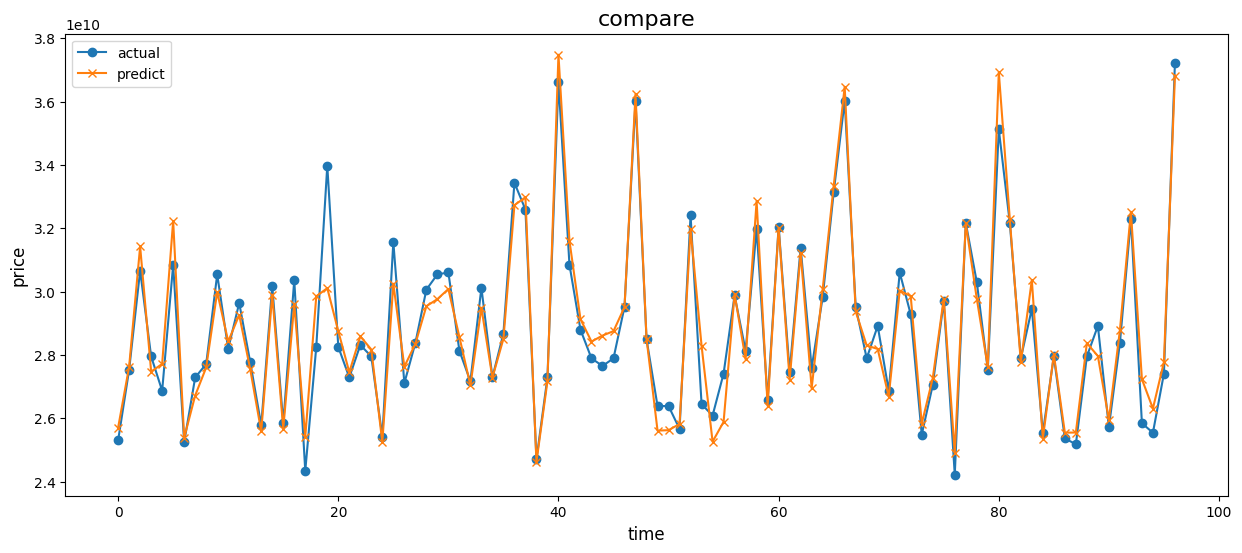

In [12]:
import matplotlib.pyplot as plt

# 예측값과 실제값 역정규화
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test, label='actual', marker='o')
plt.plot(y_pred, label='predict', marker='x')
plt.title('compare', fontsize=16)
plt.xlabel('time', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.legend()
plt.show()


In [13]:
# 마지막 test 데이터 다음날 주가 예측
last_sequence = X_test[-1]  # 마지막 시퀀스
last_sequence = last_sequence.reshape(1, seq_length, dfx.shape[1])  # 모델 입력 형태로 변환

# 다음날 주가 예측
next_day_prediction = model.predict(last_sequence)

# 역정규화
next_day_prediction = scaler_y.inverse_transform(next_day_prediction)

print("다음날 주가 예측값:", next_day_prediction[0, 0])


1/1 [==============================] - 0s 17ms/step
다음날 주가 예측값: 305602.72
